<a href="https://colab.research.google.com/github/shngxng/fall-detection-models/blob/main/hybrid_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.layers import Dense, Conv1D, Flatten, LSTM, Dropout, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential


df = pd.read_csv('/content/sample_data/combined_sensor_data-all-4.csv')

class_counts = df['class'].value_counts()

motion_features = ['light', 'motion_value', 'temp']
netatmo_features = ['CO2', "Humidity", "Noise", 'Pressure']  # and health index

uwb_features = ['breathingRate','heartRate', 'targetDistance','targetDistance_filtered' ]
health_idx_columns = ['health_idx_0', 'health_idx_1', 'health_idx_2', 'health_idx_3', 'health_idx_4']
physiologicalState_columns = ['physiologicalState_0', 'physiologicalState_1', 'physiologicalState_2','physiologicalState_3', 'physiologicalState_4']

In [44]:
# Filter rows where breathing rate is 0.0
zero_breathing_rate_rows = df[df['breathingRate'] == 0.0]
zero_breathing_rate_counts = zero_breathing_rate_rows.groupby(['PID', 'activity_name'])['breathingRate'].count()
zero_breathing_rate_counts = zero_breathing_rate_counts[zero_breathing_rate_counts > 10]

# Filter rows where breathing rate is 0.0
zero_heart_rate_rows = df[df['heartRate'] == 0.0]
zero_heart_rate_counts = zero_breathing_rate_rows.groupby(['PID', 'activity_name'])['heartRate'].count()
zero_heart_rate_counts = zero_heart_rate_counts[zero_heart_rate_counts > 10]

print("No. of breathing rate counts with 0.0 readings (outliers)")
print(zero_breathing_rate_counts)
print("\n")
print("No. of heart rate counts with 0.0 readings (outliers)")
print(zero_heart_rate_counts)

No. of breathing rate counts with 0.0 readings (outliers)
PID  activity_name
P02  SIT              24
P06  FWW1             23
P09  SIT              39
P12  SIT              20
P14  FWW1             27
P22  FFTSIT           18
P33  FFT2             27
P39  FWW              27
P40  FWW              35
     TWC1             11
P42  FWW              26
P48  FHO2             16
Name: breathingRate, dtype: int64


No. of heart rate counts with 0.0 readings (outliers)
PID  activity_name
P02  SIT              24
P06  FWW1             23
P09  SIT              39
P12  SIT              20
P14  FWW1             27
P22  FFTSIT           18
P33  FFT2             27
P39  FWW              27
P40  FWW              35
     TWC1             11
P42  FWW              26
P48  FHO2             16
Name: heartRate, dtype: int64


In [45]:
# clean ver 1
# remove the rows where PID and activity_name match the outliers
outlier_pids_activity_names = pd.concat([zero_breathing_rate_counts, zero_heart_rate_counts]).index.drop_duplicates()

df_cleaned = df.copy() # Create a copy to avoid modifying the original DataFrame

df_filtered = df_cleaned[~df_cleaned.set_index(['PID', 'activity_name']).index.isin(outlier_pids_activity_names)]

print(f"Original DataFrame size: {df_cleaned.shape}")
print(f"Filtered DataFrame size: {df_filtered.shape}")

Original DataFrame size: (39118, 27)
Filtered DataFrame size: (38745, 27)


In [46]:
# Step 1
# create sliding windows only within each activity group
def create_sliding_windows_grouped(data, window_size, step_size):
    windows = []
    labels = []
    cols_to_drop = ['class', 'timestamp', 'PID', 'activity_name']

    # Grouping the data by 'activity_name'
    grouped = data.groupby('activity_name')

    for _, group in grouped:
        group = group.reset_index(drop=True)

        # Apply sliding window to each group
        for i in range(0, len(group) - window_size + 1, step_size):
            window = group.iloc[i:i + window_size]
            windows.append(window.drop(cols_to_drop, axis=1).values)
            label = window['class'].mode()[0]  # Majority class in the window
            labels.append(label)

    return np.array(windows), np.array(labels)

window_size = 10
step_size = 3
X_windows, y_windows = create_sliding_windows_grouped(df_filtered, window_size, step_size)

In [47]:
# Step 2: Normalize the Data
# print(X_windows)
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# scaler = StandardScaler()
# X_windows_normalized = np.array([scaler.fit_transform(window) for window in X_windows])

# Step 2: Standardize the Data
scaler_standard = StandardScaler()
X_windows_standardized = np.array([scaler_standard.fit_transform(window) for window in X_windows])

# Step 2B: Normalize the Data After Standardization
scaler_normalize = MinMaxScaler(feature_range=(0, 1))
X_windows_normalized = np.array([scaler_normalize.fit_transform(window) for window in X_windows_standardized])

In [48]:
# Step 3: Reshape Data for Model Input
X_windows_normalized = X_windows_normalized.reshape((X_windows_normalized.shape[0],
                                                    X_windows_normalized.shape[1],
                                                    X_windows_normalized.shape[2]))

In [49]:
# Step 4: Apply SMOTE to Balance Classes After Windowing
from imblearn.over_sampling import SMOTE

X_flat = X_windows_normalized.reshape((X_windows_normalized.shape[0], -1))  # Flatten for SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_flat, y_windows)
print(pd.Series(y_resampled).value_counts())

1    9027
0    9027
Name: count, dtype: int64


In [50]:
from sklearn.model_selection import train_test_split

# Step 5: Reshape Back for Model Input
X_resampled = X_resampled.reshape((X_resampled.shape[0], window_size, -1))

# Step 6: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# CNN

In [51]:
def build_cnn_model(optimizer='adam', filters=32, kernel_size=3, learning_rate=0.001):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, X_train.shape[2])))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Build the model using the shape of training data
input_shape = (X_train.shape[1], X_train.shape[2])  # (window_size, number_of_features)
# model = build_cnn_model(input_shape)
cnn_model = build_cnn_model()

# Train the model
## this takes 20% of X_train and y_train as the validation set during training
cnn_history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
cnn_test_loss, cnn_test_accuracy = cnn_model.evaluate(X_test, y_test)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5779 - loss: 0.6738 - val_accuracy: 0.6355 - val_loss: 0.6368
Epoch 2/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6546 - loss: 0.6256 - val_accuracy: 0.6760 - val_loss: 0.6033
Epoch 3/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6900 - loss: 0.5853 - val_accuracy: 0.6940 - val_loss: 0.5878
Epoch 4/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.7109 - loss: 0.5618 - val_accuracy: 0.7155 - val_loss: 0.5567
Epoch 5/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7196 - loss: 0.5432 - val_accuracy: 0.7248 - val_loss: 0.5418
Epoch 6/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7419 - loss: 0.5145 - val_accuracy: 0.7092 - val_loss: 0.5533
Epoch 7/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7420 - loss: 0.5082 - val_accuracy: 0.7494 - val_loss: 0.5155
Epoch 8/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7545 - loss: 0.4932 - val_accuracy: 0.

In [52]:
def get_all_metrics(model, X_test, y_test, model_name):
    y_pred_probs = model.predict(X_test)
    y_pred = (y_pred_probs > 0.5).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    sensitivity = recall_score(y_test, y_pred) # Sensitivity (Recall)
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred) # test accuracy
    f1 = f1_score(y_test, y_pred)
    print(f"######## Confusion matrix for {model_name} model ########")
    print(f"Sensitivity (Recall): {sensitivity*100:.4f}%")
    print(f"Specificity: {specificity*100:.4f}%")
    print(f"Precision: {precision*100:.4f}%")
    print(f"Test Accuracy: {accuracy*100:.4f}%")
    print(f"F1 Score: {f1*100:.4f}%")
    print("################################################")

    metrics = {
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'Accuracy': accuracy,
        'F1': f1
    }
    return metrics

get_all_metrics(cnn_model, X_test, y_test, "CNN")

113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
######## Confusion matrix for CNN model ########
Sensitivity (Recall): 74.5878%
Specificity: 84.0173%
Precision: 81.5920%
Test Accuracy: 79.4240%
F1 Score: 77.9329%
################################################


{'Sensitivity': 0.7458783399658897,
 'Specificity': 0.8401727861771058,
 'Precision': 0.8159203980099502,
 'Accuracy': 0.7942398227637774,
 'F1': 0.7793287793287793}

# CNN-LSTM Hybrid Model

In [53]:
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Flatten, TimeDistributed
from tensorflow.keras.models import Sequential

def build_cnn_lstm_hybrid_model(optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential()
    # Apply the Conv1D layer to each time step using TimeDistributed
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'),
                                  input_shape=(window_size, X_train.shape[2], 1)))
    model.add(TimeDistributed(Flatten()))  # Flatten the output of Conv1D
    model.add(LSTM(lstm_units)) # LSTM layer
    model.add(Dense(1, activation='sigmoid')) # Output layer

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


# input shape is (time_steps, features)
cnn_lstm_model = build_cnn_lstm_hybrid_model(optimizer='adam', lstm_units=128, learning_rate=0.0005)

# Train the cnn-lstm model
cnn_lstm_history = cnn_lstm_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Evaluate the cnn-lstm model
cnn_lstm_test_loss, cnn_lstm_test_accuracy = cnn_lstm_model.evaluate(X_test, y_test)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


362/362 ━━━━━━━━━━━━━━━━━━━━ 24s 57ms/step - accuracy: 0.5849 - loss: 0.6648 - val_accuracy: 0.6199 - val_loss: 0.6302
Epoch 2/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.6599 - loss: 0.6107 - val_accuracy: 0.6750 - val_loss: 0.5890
Epoch 3/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.6832 - loss: 0.5800 - val_accuracy: 0.7096 - val_loss: 0.5607
Epoch 4/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.7086 - loss: 0.5471 - val_accuracy: 0.7155 - val_loss: 0.5307
Epoch 5/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.7378 - loss: 0.5193 - val_accuracy: 0.7342 - val_loss: 0.5210
Epoch 6/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 19s 51ms/step - accuracy: 0.7325 - loss: 0.5182 - val_accuracy: 0.7328 - val_loss: 0.5286
Epoch 7/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 21s 52ms/step - accuracy: 0.7547 - loss: 0.4926 - val_accuracy: 0.7414 - val_loss: 0.4982
Epoch 8/50
362/362 ━━━━━━━━━━━━━━━━━━━━ 23s 58ms/step - accuracy: 0.7605 - loss: 0.4724 - val_accurac

In [54]:
get_all_metrics(cnn_lstm_model, X_test, y_test, "Hybrid CNN-LSTM (ADAM)")

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
######## Confusion matrix for Hybrid CNN-LSTM (ADAM) model ########
Sensitivity (Recall): 80.1592%
Specificity: 82.3974%
Precision: 81.2212%
Test Accuracy: 81.3071%
F1 Score: 80.6867%
################################################


{'Sensitivity': 0.801591813530415,
 'Specificity': 0.8239740820734341,
 'Precision': 0.8122119815668203,
 'Accuracy': 0.8130711714206591,
 'F1': 0.8068669527896996}

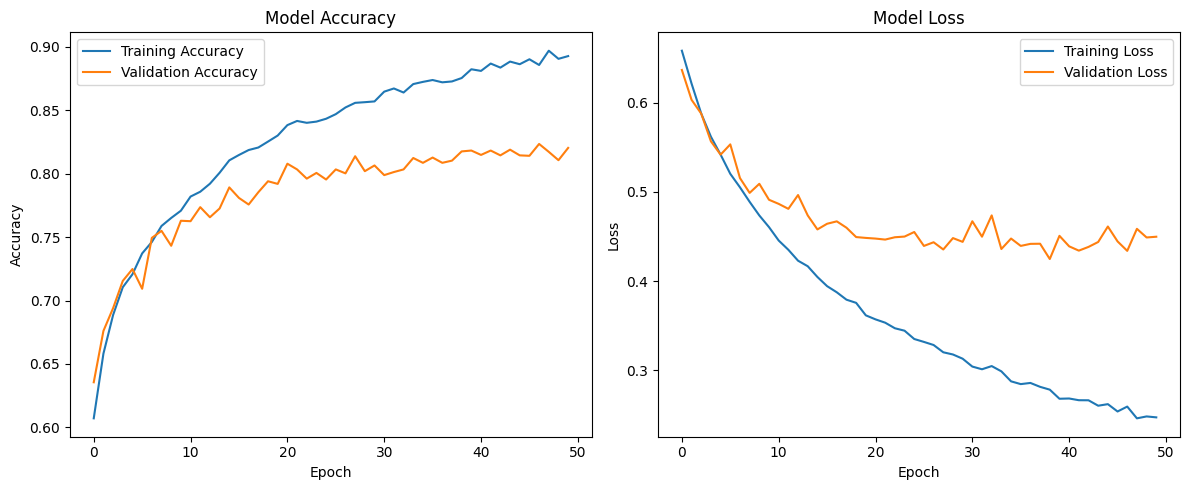

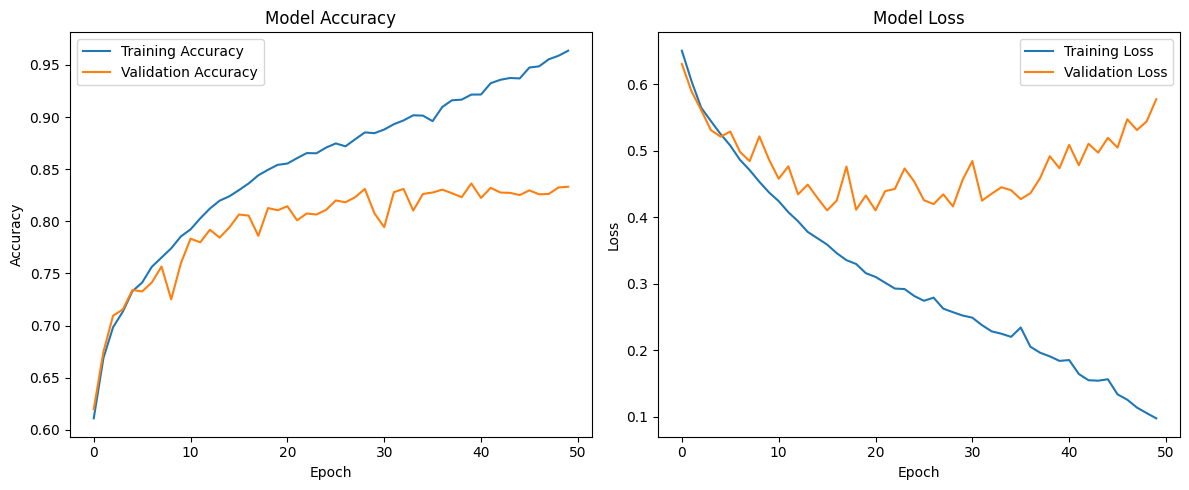

In [55]:
def plot_performance(history):
    # plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    # accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_performance(cnn_history)
plot_performance(cnn_lstm_history)

In [59]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score  # Use appropriate metrics for your problem

# Assuming X_resampled and y_resampled are already prepared

# Step 6: Set Up 10-Fold Cross-Validation
def k_fold_validation(k, model):
  kf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
  fold = 1
  validation_accuracies = []

  # Loop through each fold
  for train_index, val_index in kf.split(X_resampled, y_resampled):
      # Split the data
      # X_train, X_test = X_resampled[train_index], X_resampled[test_index]
      # y_train, y_test = y_resampled[train_index], y_resampled[test_index]

      X_train_fold, X_val_fold = X_resampled[train_index], X_resampled[val_index]
      y_train_fold, y_val_fold = y_resampled[train_index], y_resampled[val_index]


      # Step 7: Train Your Model (replace with your model)
      model.fit(X_train_fold, y_train_fold)

      # Step 8: Evaluate Your Model
      # y_pred = model.predict(X_test)
      # # to binary prediction
      # y_pred = (y_pred > 0.5).astype(int)

      # y_val_pred = model.predict(X_val_fold)
      # accuracy = accuracy_score(y_val_fold, y_val_pred)
      # validation_accuracies.append(accuracy)


      # Calculate accuracy score
      # accuracy = accuracy_score(y_test, y_pred)
      # accuracy_scores.append(accuracy)

      # Step 4: Validate the Model on the Validation Fold
      val_loss, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
      validation_accuracies.append(accuracy)

      print(f'Fold {fold} - Accuracy: {accuracy:.4f}')
      fold += 1

  # Step 9: Calculate Average Accuracy Across All Folds
  average_accuracy = np.mean(validation_accuracies)
  print(f'Average Accuracy: {average_accuracy:.4f}')

cnn_lstm_model1 = build_cnn_lstm_hybrid_model(optimizer='adam', lstm_units=128, learning_rate=0.0005)
k_fold_validation(10, cnn_lstm_model1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 27s 47ms/step - accuracy: 0.6038 - loss: 0.6534
Fold 1 - Accuracy: 0.6556
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.6906 - loss: 0.5822
Fold 2 - Accuracy: 0.7010
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7161 - loss: 0.5483
Fold 3 - Accuracy: 0.7099
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7227 - loss: 0.5290
Fold 4 - Accuracy: 0.7536
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7430 - loss: 0.5020
Fold 5 - Accuracy: 0.7729
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7624 - loss: 0.4755
Fold 6 - Accuracy: 0.7590
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.7727 - loss: 0.4556
Fold 7 - Accuracy: 0.7701
508/508 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.7884 - loss: 0.4334
Fold 8 - Accuracy: 0.7983
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7948 - loss: 0.4246
Fold 9 - Accuracy: 0.8266
508/508 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.7963 - loss: 0.4

In [61]:
cnn_lstm_model2 = build_cnn_lstm_hybrid_model(optimizer='adam', lstm_units=64, learning_rate=0.001)
k_fold_validation(10, cnn_lstm_model2)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step - accuracy: 0.6069 - loss: 0.6549
Fold 1 - Accuracy: 0.6456
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.6995 - loss: 0.5744
Fold 2 - Accuracy: 0.7187
508/508 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7273 - loss: 0.5335
Fold 3 - Accuracy: 0.7409
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7382 - loss: 0.5071
Fold 4 - Accuracy: 0.7702
508/508 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7630 - loss: 0.4746
Fold 5 - Accuracy: 0.7828
508/508 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.7875 - loss: 0.4397
Fold 6 - Accuracy: 0.7839
508/508 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - accuracy: 0.7968 - loss: 0.4214
Fold 7 - Accuracy: 0.7994
508/508 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8089 - loss: 0.3946
Fold 8 - Accuracy: 0.8211
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 32ms/step - accuracy: 0.8202 - loss: 0.3784
Fold 9 - Accuracy: 0.8327
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8308 - loss: 0.3

In [62]:
cnn_lstm_model3 = build_cnn_lstm_hybrid_model(optimizer='adam', lstm_units=128, learning_rate=0.001)
k_fold_validation(10, cnn_lstm_model3)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 29s 49ms/step - accuracy: 0.6012 - loss: 0.6555
Fold 1 - Accuracy: 0.6512
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.6672 - loss: 0.5987
Fold 2 - Accuracy: 0.6916
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.7016 - loss: 0.5557
Fold 3 - Accuracy: 0.6872
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 48ms/step - accuracy: 0.7146 - loss: 0.5453
Fold 4 - Accuracy: 0.7386
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7408 - loss: 0.5040
Fold 5 - Accuracy: 0.7651
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.7679 - loss: 0.4628
Fold 6 - Accuracy: 0.7850
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.7896 - loss: 0.4319
Fold 7 - Accuracy: 0.8028
508/508 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.8082 - loss: 0.4026
Fold 8 - Accuracy: 0.8238
508/508 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8217 - loss: 0.3748
Fold 9 - Accuracy: 0.8366
508/508 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.8372 - loss: 0.3

In [69]:
cnn_lstm_model4 = build_cnn_lstm_hybrid_model(optimizer='adam', lstm_units=64, learning_rate=0.005)
k_fold_validation(10, cnn_lstm_model4)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


508/508 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - accuracy: 0.6000 - loss: 0.6542
Fold 1 - Accuracy: 0.6733
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7011 - loss: 0.5637
Fold 2 - Accuracy: 0.7348
508/508 ━━━━━━━━━━━━━━━━━━━━ 18s 34ms/step - accuracy: 0.7509 - loss: 0.4958
Fold 3 - Accuracy: 0.7569
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 34ms/step - accuracy: 0.7906 - loss: 0.4308
Fold 4 - Accuracy: 0.7940
508/508 ━━━━━━━━━━━━━━━━━━━━ 18s 35ms/step - accuracy: 0.8198 - loss: 0.3785
Fold 5 - Accuracy: 0.7945
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8332 - loss: 0.3575
Fold 6 - Accuracy: 0.8460
508/508 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8525 - loss: 0.3158
Fold 7 - Accuracy: 0.8565
508/508 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.8636 - loss: 0.3020
Fold 8 - Accuracy: 0.8626
508/508 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.8778 - loss: 0.2795
Fold 9 - Accuracy: 0.8837
508/508 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.8860 - loss: 0.2

In [77]:
cnn_lstm_model4.fit(X_train, y_train)

# Evaluate the model on the test set
# y_test_pred = cnn_lstm_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)
# print(f'Test Accuracy: {test_accuracy:.4f}')

# final_model = build_cnn_lstm_hybrid_model(optimizer='adam', lstm_units=64, learning_rate=0.0005)
# y_test_pred = final_model.predict(X_test)
# test_accuracy = accuracy_score(y_test, y_test_pred)

cnn_lsm_test_loss4, cnn_lstm_test_accuracy4 = cnn_lstm_model4.evaluate(X_test, y_test)
print(f"Test Accuracy: {cnn_lstm_test_accuracy4*100:.4f}%")

452/452 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9400 - loss: 0.1454
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8910 - loss: 0.2810
Test Accuracy: 88.2027%


In [72]:
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

def build_cnn_lstm_hybrid_model2(optimizer='adam', filters=32, kernel_size=3, lstm_units=64, learning_rate=0.001):
    model = Sequential()

    # Apply the Conv1D layer to each time step using TimeDistributed
    model.add(TimeDistributed(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu',
                                     kernel_regularizer=l2(0.001)),
                              input_shape=(window_size, X_train.shape[2], 1)))
    model.add(TimeDistributed(BatchNormalization()))
    model.add(TimeDistributed(Flatten()))  # Flatten the output of Conv1D

    # LSTM layer with dropout
    model.add(LSTM(lstm_units, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Optimizer setup
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Use this revised model for training
cnn_lstm_model2_1 = build_cnn_lstm_hybrid_model2(optimizer='adam', lstm_units=64, learning_rate=0.0005)
k_fold_validation(10, cnn_lstm_model2_1)


cnn_lstm_model2_1.fit(X_train, y_train)

cnn_lsm_test_loss2_1, cnn_lstm_test_accuracy2_1 = cnn_lstm_model2_1.evaluate(X_test, y_test)
print(f"Test Accuracy: {cnn_lstm_test_accuracy2_1*100}")

508/508 ━━━━━━━━━━━━━━━━━━━━ 28s 46ms/step - accuracy: 0.6129 - loss: 0.9121
Fold 1 - Accuracy: 0.6800
508/508 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.7133 - loss: 0.6757
Fold 2 - Accuracy: 0.7519
508/508 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.7563 - loss: 0.5932
Fold 3 - Accuracy: 0.7769
508/508 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7749 - loss: 0.5499
Fold 4 - Accuracy: 0.7913
508/508 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.7872 - loss: 0.5124
Fold 5 - Accuracy: 0.7884
508/508 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.7942 - loss: 0.5007
Fold 6 - Accuracy: 0.8133
508/508 ━━━━━━━━━━━━━━━━━━━━ 22s 44ms/step - accuracy: 0.8041 - loss: 0.4813
Fold 7 - Accuracy: 0.8078
508/508 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8168 - loss: 0.4649
Fold 8 - Accuracy: 0.8216
508/508 ━━━━━━━━━━━━━━━━━━━━ 23s 45ms/step - accuracy: 0.8193 - loss: 0.4496
Fold 9 - Accuracy: 0.8416
508/508 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.8292 - loss: 0.4